In [1]:
### uncomment to display figures
%matplotlib inline   

# Using the AWRA MS to run a Simulation of the AWRA-L model
There are two ways to run a simulation of the AWRA-L model in the AWRA MS
* Using the On-Demand Simulator
* Using the Server Simulator

This notebook outlines how to run a basic on-demand AWRA-L simulation and get into more detail about how to change the model configuration (nodegraph) to define the inputs to the simulation.

## On-Demand Simulation
The AWRA MS On-Demand Simulator is designed to run the model for a few years over a small extent. It allows the user to quickly and efficiently assess the impact of changes made to the model or inputs without the need to write all of the outputs to file. The user can write the results out but it is generally designed to hold the results in memory for visualisation and checking.<br><br>

This notebook outlines a basic On-Demand Simulation of the AWRA-L model and go through some of the options and functionality available from the package to modify a model run and inspect the outputs.


This notebook goes through the following steps:

1. Import required libraries
2. Quick example: the default model run<br>
3. Modifying the model configuration <br>
 3.1 Change forcing data<br>
 3.2 Change spatial grids<br>
 3.3 Change parameter values<br>
4. Put model run specification together<br>
 4.1 Instantiate the simulator<br>
 4.2 Specify period and extents<br>
 4.3 Run the model<br>
5. Configuring model outputs<br>
 5.1 Check what outputs are available<br>
 5.2 Add new output<br>
 5.3 Save outputs to files<br>
6. Quickly viewing model run outputs held in memory<br>
 6.1 Viewing 1-D outputs<br>
 6.2 Viewing 2-D outputs<br>
7. More examples<br>
 7.1 Run over entire continent<br>
 7.2 Run with uniform rain<br>
6. Exercise

### 1. Import required libraries

In [2]:
## Standard Python packages
import numpy as np
from matplotlib import pyplot as plt

In [3]:
## AWRAMS utilities
from awrams.utils import extents
from awrams.utils import datetools as dt

In [4]:
## AWRAMS input nodegraph. The nodegraph is created when building the input mapping
from awrams.utils.nodegraph import nodes

In [5]:
## Select simulation option
from awrams.simulation import ondemand


## Select AWRA model
from awrams.models import awral

### 2. Quick example: run the default model and settings

Quick example to show you where we are heading

In [6]:
awralmod = awral.model.AWRALModel()

awral.model.CLIMATE_DATA 

'/data/cwd_awra_data/AWRACMS/Training/test_data/climate/BOM_climate/'

In [7]:
awral.model.FORCING

{'precip': ('rain_day/rain*', 'rain_day'),
 'solar': ('solar_exposure_day/solar*', 'solar_exposure_day'),
 'tmax': ('temp_max_day/temp_max*', 'temp_max_day'),
 'tmin': ('temp_min_day/temp_min*', 'temp_min_day')}

In [8]:
## If you wanted to override this
awral.model.FORCING = {'precip': ('rain_day/rain*', 'rain_day'),
                       'solar': ('solar_exposure_day/solar*', 'solar_exposure_day'),
                       'tmax': ('temp_max_day/temp_max*', 'temp_max_day'),
                       'tmin': ('temp_min_day/temp_min*', 'temp_min_day')}

### 3. Modifying the model configuration


#### 3.1 Read in  default input nodegraph

In [9]:
input_map = awralmod.get_default_mapping()

In [10]:
input_map

alb_dry_hrudr : parameter([]):{'max': 0.5, 'min': 0.1, 'value': 0.26, 'fixed': True}
alb_dry_hrusr : parameter([]):{'max': 0.5, 'min': 0.1, 'value': 0.26, 'fixed': True}
alb_wet_hrudr : parameter([]):{'max': 0.5, 'min': 0.1, 'value': 0.16, 'fixed': True}
alb_wet_hrusr : parameter([]):{'max': 0.5, 'min': 0.1, 'value': 0.16, 'fixed': True}
avpt : transform(['tmin']):{'func_args': {}, 'tfunc': {'objtype': 'class', 'name': 'pe', 'module': 'awrams.models.awral.transforms'}}
cgsmax_hrudr : parameter([]):{'max': 0.05, 'min': 0.02, 'value': 0.0320045265678736, 'fixed': False}
cgsmax_hrusr : parameter([]):{'max': 0.05, 'min': 0.02, 'value': 0.02371068048102, 'fixed': False}
er_frac_ref_hrudr : parameter([]):{'max': 0.25, 'min': 0.04, 'value': 0.0735562467806121, 'fixed': False}
er_frac_ref_hrusr : transform(('er_frac_ref_hrudr', 0.5)):{'func_args': {}, 'tfunc': {'objtype': 'class', 'name': 'multiply', 'module': 'numpy'}}
f_tree_grid : spatial_from_file([]):{'filename': '/data/cwd_awra_data/AWRA

In [11]:
# Display the configuration
# for k in input_map: 
#     print(k,input_map[k])
   

In [12]:
input_map['hveg_hrusr']

parameter([]):{'max': 50, 'min': 0.1, 'value': 0.5, 'fixed': True}

Changing the inputs to the model can be done by changing the values of the items in the nodegraph. <br> We will do this by means of functions taking in an input map (basically a dictionary in the form key: value) and replacing the values as we see appropriate.

#### 3.1 Change forcing inputs

In [13]:
# Create a function than will take in an existing configuration and modify the forcing items only.

def change_path_to_forcing(imap):
    from awrams.utils.nodegraph import nodes # the nodes library contains various functions that are useful for nodegraph changes

    imap = imap.copy()

    data_path = '../../test_data/simulation/' # we have a smaller set of data provided as part of the repo
    FORCING = {
        'tmin': (data_path,'temp_min*.nc','temp_min_day'),
        'tmax': (data_path,'temp_max*.nc','temp_max_day'),
        'precip': (data_path,'rain_day*.nc','rain_day'),
        'solar': (data_path,'solar*.nc','solar_exposure_day') #,
    }
    for k,v in FORCING.items():
        imap[k+'_f'] = nodes.forcing_from_ncfiles(v[0],v[1],v[2])  # function nodes.forcing_from_ncfiles reads in the 
                                                                           # path, file name and variable name
    
    return imap

In [14]:
input_map['tmax_f']

forcing_from_ncfiles([]):{'nc_var': 'temp_max_day', 'cache': False, 'path': '/data/cwd_awra_data/AWRACMS/Training/test_data/climate/BOM_climate/', 'pattern': 'temp_max_day/temp_max*'}

#### 3.2 Changing the spatial input grids

In [15]:
awral.settings.SPATIAL_FILE

'/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/models/awral/data/spatial_parameters.h5'

In [16]:
import h5py

h = h5py.File(awral.settings.SPATIAL_FILE,'r+')

In [17]:
list(h['parameters'].keys())

['f_tree',
 'height',
 'hveg_dr',
 'k0sat_v5',
 'k_gw',
 'kdsat_v5',
 'kssat_v5',
 'lai_max',
 'meanPET',
 'ne',
 'pref',
 's0fracAWC',
 'slope',
 'ssfracAWC',
 'windspeed']

In [18]:
kdsat_grid = h['parameters']['kdsat_v5'][:]

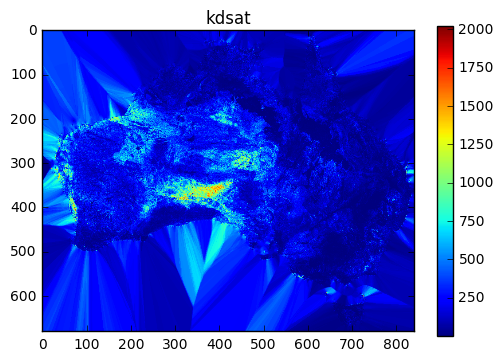

In [19]:
im = plt.imshow(kdsat_grid) 
plt.title("kdsat")
plt.colorbar(im)

#Don't panic at the disco effect. Grids have been infilled to cater for potential edge effects

In [20]:
# Couple of ways you can look at the mapping for a particular grid
input_map['kdsat_v5_grid']

spatial_from_file([]):{'filename': '/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/models/awral/data/spatial_parameters.h5', 'variable': 'parameters/kdsat_v5', 'preload': False}

In [21]:
input_map.kdsat_v5_grid

spatial_from_file([]):{'filename': '/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/models/awral/data/spatial_parameters.h5', 'variable': 'parameters/kdsat_v5', 'preload': False}

In [22]:
# If you want to modify any of the arguments
input_map.kdsat_v5_grid.args

{'filename': '/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/models/awral/data/spatial_parameters.h5', 'variable': 'parameters/kdsat_v5', 'preload': False}

In [23]:
# If you want to modify any of the arguments
input_map.kdsat_v5_grid.args['filename']

'/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/models/awral/data/spatial_parameters.h5'

In [24]:
# The nodes library allows you to point to different grid file (.nc, .flt, anything ecognised by gdal) to load up the data
# input_map.f_tree_grid = nodes.spatial_from_file(PATH_TO_NEW_FTREE_FILE)

#### 3.3 How to change a parameter

In [25]:
from awrams.models.awral.settings import DEFAULT_PARAMETER_FILE

DEFAULT_PARAMETER_FILE

'/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/models/awral/data/DefaultParameters.json'

In [26]:
# view default parameter set
import json
import pandas as pd
model_paramset = json.load(open(DEFAULT_PARAMETER_FILE,'r'))
model_paramset

[{'DecimalPlaces': 0,
  'DisplayName': 'HRU:DR Dry Soil Albedo',
  'Fixed': True,
  'Max': 0.5,
  'MemberName': 'alb_dry_hruDR',
  'Min': 0.1,
  'Value': 0.26},
 {'DecimalPlaces': 0,
  'DisplayName': 'HRU:SR Dry Soil Albedo',
  'Fixed': True,
  'Max': 0.5,
  'MemberName': 'alb_dry_hruSR',
  'Min': 0.1,
  'Value': 0.26},
 {'DecimalPlaces': 0,
  'DisplayName': 'HRU:DR Wet Soil Albedo',
  'Fixed': True,
  'Max': 0.5,
  'MemberName': 'alb_wet_hruDR',
  'Min': 0.1,
  'Value': 0.16},
 {'DecimalPlaces': 0,
  'DisplayName': 'HRU:SR Wet Soil Albedo',
  'Fixed': True,
  'Max': 0.5,
  'MemberName': 'alb_wet_hruSR',
  'Min': 0.1,
  'Value': 0.16},
 {'DecimalPlaces': 0,
  'DisplayName': 'HRU:DR Conversion Coefficient From Vegetation Photosynthetic Capacity Index to Maximum Stomatal Conductance',
  'Fixed': False,
  'Max': 0.05,
  'MemberName': 'cGsmax_hruDR',
  'Min': 0.02,
  'Value': 0.0320045265678736},
 {'DecimalPlaces': 0,
  'DisplayName': 'HRU:SR Conversion Coefficient From Vegetation Photosyn

In [27]:
param_df = pd.DataFrame(model_paramset)
param_df

,DecimalPlaces,DisplayName,Fixed,Max,MemberName,Min,Value
0,0,HRU:DR Dry Soil Albedo,True,0.50,alb_dry_hruDR,0.100,0.260000
1,0,HRU:SR Dry Soil Albedo,True,0.50,alb_dry_hruSR,0.100,0.260000
2,0,HRU:DR Wet Soil Albedo,True,0.50,alb_wet_hruDR,0.100,0.160000
3,0,HRU:SR Wet Soil Albedo,True,0.50,alb_wet_hruSR,0.100,0.160000
4,0,HRU:DR Conversion Coefficient From Vegetation ...,False,0.05,cGsmax_hruDR,0.020,0.032005
5,0,HRU:SR Conversion Coefficient From Vegetation ...,False,0.05,cGsmax_hruSR,0.020,0.023711
6,0,HRU:DR Ratio of Average Evaporation Rate Over ...,False,0.25,ER_frac_ref_hruDR,0.040,0.073556
7,0,HRU:DR Soil Evaporation Scaling Factor When So...,False,1.00,FsoilEmax_hruDR,0.200,0.227466
8,0,HRU:SR Soil Evaporation Scaling Factor When So...,False,1.00,FsoilEmax_hruSR,0.200,0.929708
9,0,HRU:DR Reference Soil Cover Fraction That Dete...,True,0.25,fvegref_G_hruDR,0.100,0.150000


In [28]:
## This function basically allows us to replace default parameters by new values
## we will place parameters (the ones that can potentially be calibrated) defined in a pandas dataframe into the model input_map

def change_model_parameters(imap, param_df):
    """
    the intent of this function is to replace the values in imap (your current configuration) 
    by values in a new parameter dataframe (param_df)
    """
    
    import pandas as pd
    
    variable_names = param_df['MemberName']
    variable_value = param_df['Value']
    variable_fixed = param_df['Fixed']
    variable_max = param_df['Max']
    variable_min = param_df['Min']
    # Convert to lower case for the input_mapping
      
    for k,v,f,vmax,vmin in zip(variable_names,variable_value, variable_fixed, variable_max, variable_min):
        imap[k.lower()].args['value'] = v
        imap[k.lower()].args['fixed'] = f
        imap[k.lower()].args['max'] = vmax
        imap[k.lower()].args['min'] = vmin



In [29]:
param_df.loc[param_df['MemberName']=='RD_hruSR','Value'] = 2

In [30]:
change_model_parameters(input_map, param_df)

In [31]:
input_map

alb_dry_hrudr : parameter([]):{'max': 0.5, 'min': 0.10000000000000001, 'value': 0.26000000000000001, 'fixed': True}
alb_dry_hrusr : parameter([]):{'max': 0.5, 'min': 0.10000000000000001, 'value': 0.26000000000000001, 'fixed': True}
alb_wet_hrudr : parameter([]):{'max': 0.5, 'min': 0.10000000000000001, 'value': 0.16, 'fixed': True}
alb_wet_hrusr : parameter([]):{'max': 0.5, 'min': 0.10000000000000001, 'value': 0.16, 'fixed': True}
avpt : transform(['tmin']):{'func_args': {}, 'tfunc': {'objtype': 'class', 'name': 'pe', 'module': 'awrams.models.awral.transforms'}}
cgsmax_hrudr : parameter([]):{'max': 0.050000000000000003, 'min': 0.02, 'value': 0.032004526567873601, 'fixed': False}
cgsmax_hrusr : parameter([]):{'max': 0.050000000000000003, 'min': 0.02, 'value': 0.023710680481019999, 'fixed': False}
er_frac_ref_hrudr : parameter([]):{'max': 0.25, 'min': 0.040000000000000001, 'value': 0.073556246780612095, 'fixed': False}
er_frac_ref_hrusr : transform(('er_frac_ref_hrudr', 0.5)):{'func_args'

### 4. Put model run specification together

Like we did at the start for the default version

#### 4.1	Instantiate the simulator

In [34]:
OnDemandSim = ondemand.OnDemandSimulator(awralmod,input_map)

#### 4.2	Define the required period and spatial extent

In [35]:
period = dt.dates('dec 2010 - jan 2011')

In [36]:
## Set the starting extent as the extent of the AWAP grid
## in the background this picks up the geospatial references associated with the grid set as default in the configuration file 
## Config.py ?

edef = extents.get_default_extent()

In [37]:
## Select a sub-area of that grid, say the Perth region [450 grid cells south, 20 grid cells across]

esub = edef.ioffset[400:450,50:100]

In [38]:
esub

origin: -30.0,114.5, shape: (50, 50), cell_size: 0.05

#### 4.3 Run the model for the defined extent and period

In [39]:
r = OnDemandSim.run(period,extent=esub)



A switch is available in the model run command that allows the process to capture the inputs, i,e.  forcing data and grid values that apply specifically to the extent run.


In [40]:
## 4.3.1 Option to capture model inputs

r, ires = OnDemandSim.run(period,esub,True) # r holds  model outputs, ires holds model gridded inputs/parameters

In [41]:
ires

{0.5: 0.5,
 1.0: 1.0,
 2.0: 2.0,
 'vc_hrudr': 0.34999999999999998,
 's0max': array([ 43.14023972,  14.97925091,  17.31357956, ...,  14.97925091,
         14.97925091,  14.97925091], dtype=float32),
 'alb_dry_hrudr': 0.26000000000000001,
 'laimax_hrusr': array([ 0.96000004,  0.96000004,  1.65200007, ...,  2.82800007,
         2.63600016,  2.2566669 ], dtype=float32),
 'kr_sd': array([ 3.02933431,  3.16155577,  3.05861831, ...,  5.36785936,
         4.76206255,  4.81495476], dtype=float32),
 'alb_wet_hrusr': 0.16,
 'meanpet_grid': array([ 6.05229521,  6.06272125,  6.02640247, ...,  4.47978258,
         4.56611395,  4.60934925], dtype=float32),
 'laimax_hrudr': array([ 0.96000004,  0.96000004,  1.65200007, ...,  2.82800007,
         2.63600016,  2.2566669 ], dtype=float32),
 'tmax': array([[ 28.82999992,  29.22999954,  29.63999939, ...,  29.75      ,
          29.92000008,  29.81999969],
        [ 25.70999908,  25.97999954,  26.25      , ...,  26.61000061,
          26.79000092,  26.70000

In [42]:
## E.g. view forcings
forcing = ('tmin_f','tmax_f','solar_f','precip_f', 'u2t')

clm = {k:ires[k] for k in forcing}


In [43]:
clm['precip_f'].shape

(62, 1602)

### 5. Configuring model outputs

#### 5.1 Check what outputs are available

Should be as per what's in the default output mapping + an extra one for the model states captured to be able to hotstart

In [44]:
r.keys() # this is to see what's in the model run outputs

dict_keys(['sd_hrusr', 'mleaf_hrudr', 's0_hrudr', 'ss', 'qtot', 'mleaf_hrusr', 's0_hrusr', 'dd', 'sd', 'ss_hrusr', 'sr', 'final_states', 'ss_hrudr', 'e0', 'sd_hrudr', 'etot', 's0', 'sg'])

In [45]:
r['ss_hrusr']

array([[  59.14972151,   52.39277049,   51.61301026, ...,  106.43728888,
         106.28906634,  106.09083665],
       [  55.84062366,   47.10506228,   44.7127814 , ...,  101.49080397,
         100.86090823,  101.07974464],
       [  50.03172435,   40.75269457,   37.302985  , ...,   97.48582264,
          96.43379343,   96.98550532],
       ..., 
       [   1.40551594,    2.50933683,    2.83167797, ...,    4.32575599,
           4.1813607 ,    3.86894543],
       [   3.03523288,    4.14886125,    4.2654218 , ...,   12.33673316,
          11.80357185,   10.21500349],
       [   4.10244692,    4.94945026,    5.14585548, ...,   13.18006557,
          12.49617596,   10.98374063]])

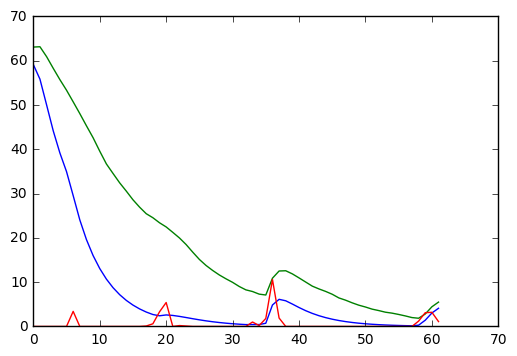

In [46]:
# For the first cell of the extent over the entire period of modelling
# the starting point is a function of the initial state used. 

plt.plot(r['ss_hrusr'][:,0])  # in blue
plt.plot(r['ss_hrudr'][:,0])  # in green

# can also add the model inputs
plt.plot(ires['precip_f'][:,0]) # in red

#### 5.2 Add extra outputs to the model

In [49]:
# See the currently selected set of model outputs
awralmod.OUTPUTS

{'OUTPUTS_AVG': ['e0', 'etot', 'dd', 's0', 'ss', 'sd'],
 'OUTPUTS_CELL': ['qtot', 'sr', 'sg'],
 'OUTPUTS_HRU': ['s0', 'ss', 'sd', 'mleaf']}

In [50]:
# Add mleaf, which is available per hru, to the averaged outputs

awralmod.OUTPUTS['OUTPUTS_AVG'].append('mleaf')

In [51]:
# Turn on the individual HRU outputs for e0

awralmod.OUTPUTS['OUTPUTS_HRU'].append('e0')

In [52]:
## Run a simulation with the new outputs

runner = ondemand.OnDemandSimulator(awralmod,input_map)
r = runner.run(period,extent=esub)

In [53]:
r['mleaf'].shape

(62, 1602)

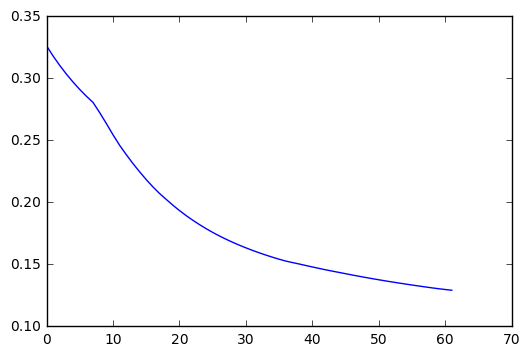

In [54]:
# Examine mleaf

plt.plot(r['mleaf'][:,0])  # in blue

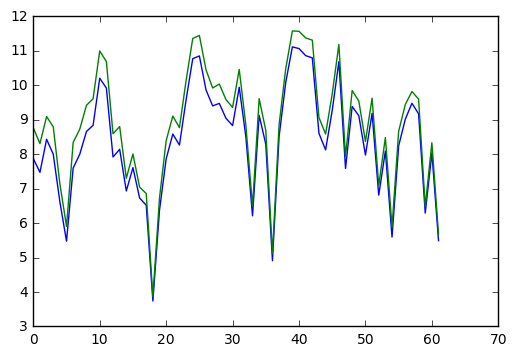

In [55]:
# Examine e0

plt.plot(r['e0_hrusr'][:,0])  # in blue
plt.plot(r['e0_hrudr'][:,0])  # in green

#### 5.3 Save outputs to file

The onDemand simulator is not set up by default with an output mapping, so does not write out anything. <br>
However, if you want to files can be output readily

In [56]:
def build_output_mapping(model):
    from awrams.utils.nodegraph import nodes

    output_map = model.get_output_mapping()

    outpath = './_results/'
    
    output_map['s0_ncsave'] = nodes.write_to_annual_ncfile(outpath,'s0')
    output_map['ss_ncsave'] = nodes.write_to_annual_ncfile(outpath,'ss')
    output_map['sd_ncsave'] = nodes.write_to_annual_ncfile(outpath,'sd')
    
    return output_map


In [57]:
omap = build_output_mapping(awralmod)

In [ ]:
## Re-run

In [58]:
runner_with_outputs = ondemand.OnDemandSimulator(awralmod,input_map,omapping=omap)

In [59]:
period = dt.dates('dec 2010 - jan 2011')
r, ires = runner_with_outputs.run(period,esub,True)

Additional things you can do with the model configuration, such as changing initial states and infilling gaps in the forcing inputs are presented in the [SimulationServer] notebook

[SimulationServer]: ./SimulationServer.ipynb


### 6. Quickly viewing model run outputs held in memory

The model ouputs can be gathered into numpy arrays by using functionality available in the nodes library. <br>
That way, 1D and 2D arrays can be visualised using usual matplotlib commands (plt.plot, plt.imshow)

#### 6.1 View 1-D ouputs
Example for multiple ouputs on single time series graph of catchment average

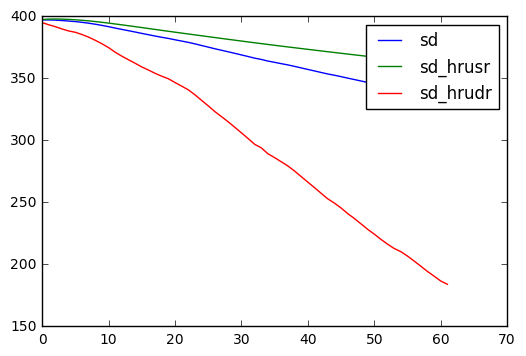

In [60]:
for v in ['sd','sd_hrusr','sd_hrudr']:
    plt.plot(r[v].mean(axis=1),label=v)
plt.legend()

#### 6.2 View 2-D outputs 

In [61]:
nodes.get_expanded(r['sd'][0],esub.mask)

masked_array(data =
 [[-- -- -- ..., 511.81616993368476 495.4767197655839 495.3851941328383]
 [-- -- -- ..., 511.8023464627362 511.8817058641211 508.7091123796555]
 [-- -- -- ..., 511.9534756873185 511.84697057477035 512.1667294371091]
 ..., 
 [-- -- -- ..., 477.1237510847895 440.85104128410893 477.18283880381387]
 [-- -- -- ..., 477.0540413099633 375.5022237494674 477.2681763168161]
 [-- -- -- ..., 477.21548728982475 477.33359844003735 477.12246500376943]],
             mask =
 [[ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 ..., 
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]],
       fill_value = nan)

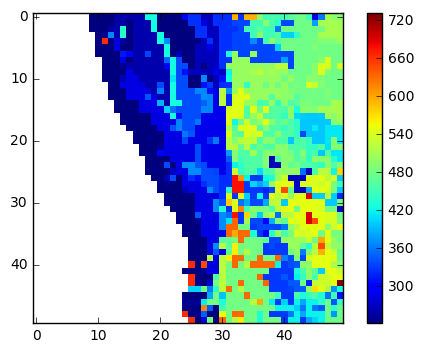

In [62]:
im = plt.imshow(nodes.get_expanded(r['sd'][0],esub.mask),interpolation='None')
plt.colorbar(im)

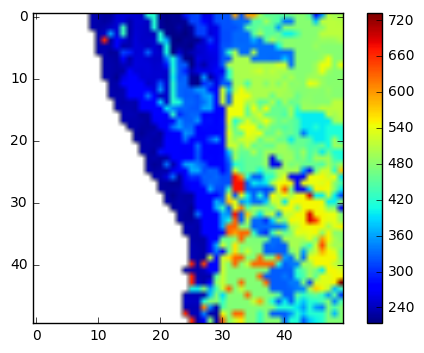

In [63]:
im = plt.imshow(nodes.get_expanded(r['sd'][10],esub.mask)) #,interpolation='None')
plt.colorbar(im)

### 7. More examples

#### 7.1 Run over the entire continent. 
Just for one day. Likely to have memory issues if want to run for long periods.
2MB per output variable per day.

In [64]:
period = dt.dates('jan 1 2011')
r, ires = runner.run(period,edef, True) # r holds  model outputs, ires holds model gridded inputs/parameters

In [65]:
from matplotlib import rcParams
rcParams['figure.figsize'] = [12.,8.]

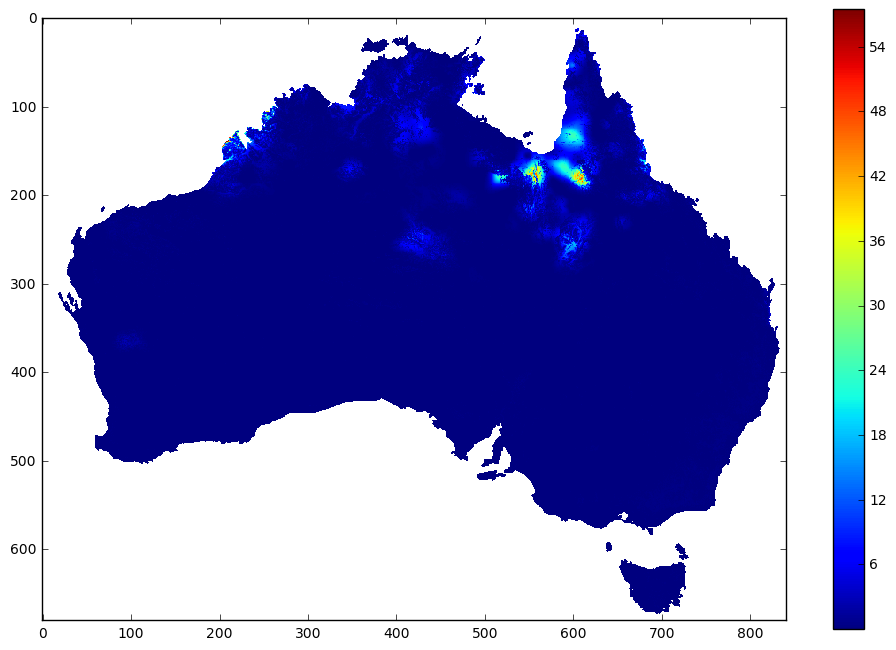

In [66]:
im = plt.imshow(nodes.get_expanded(r['qtot'][0],edef.mask),interpolation='None')
plt.colorbar(im)

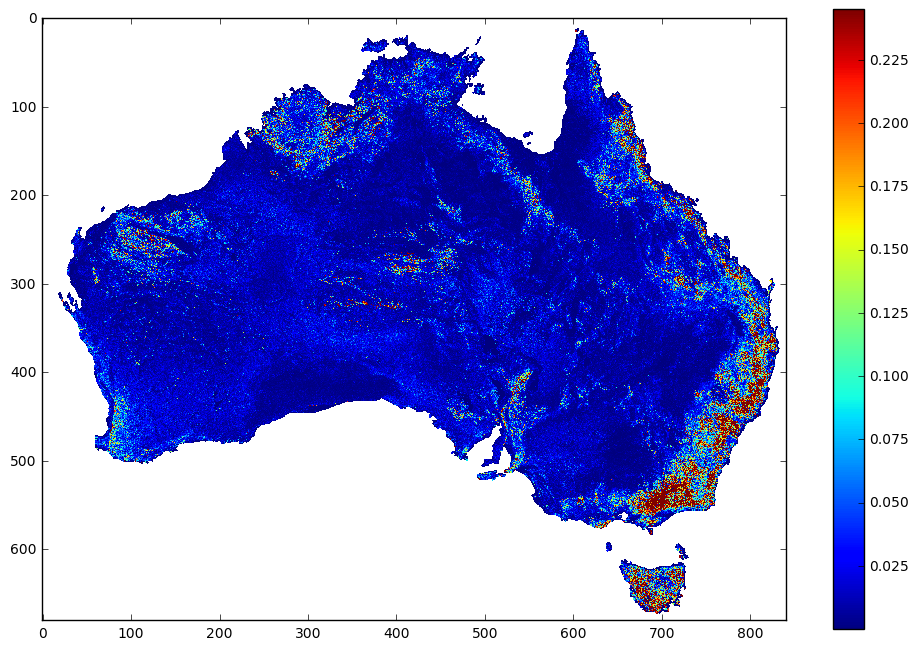

In [67]:
# Also  view slope gridded input

im = plt.imshow(nodes.get_expanded(ires['slope'],edef.mask),interpolation='None')
plt.colorbar(im)

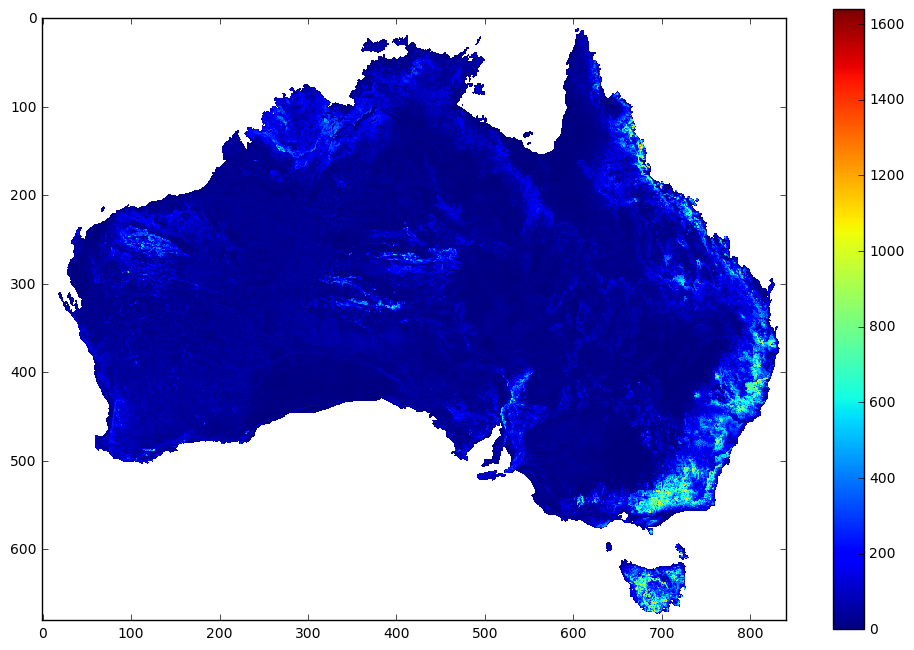

In [68]:
# Grid cell elevation range (highest point of hypsometric curve  - lowest point)

im = plt.imshow(nodes.get_expanded(ires['height'][-1]-ires['height'][0],edef.mask),interpolation='None')
plt.colorbar(im)

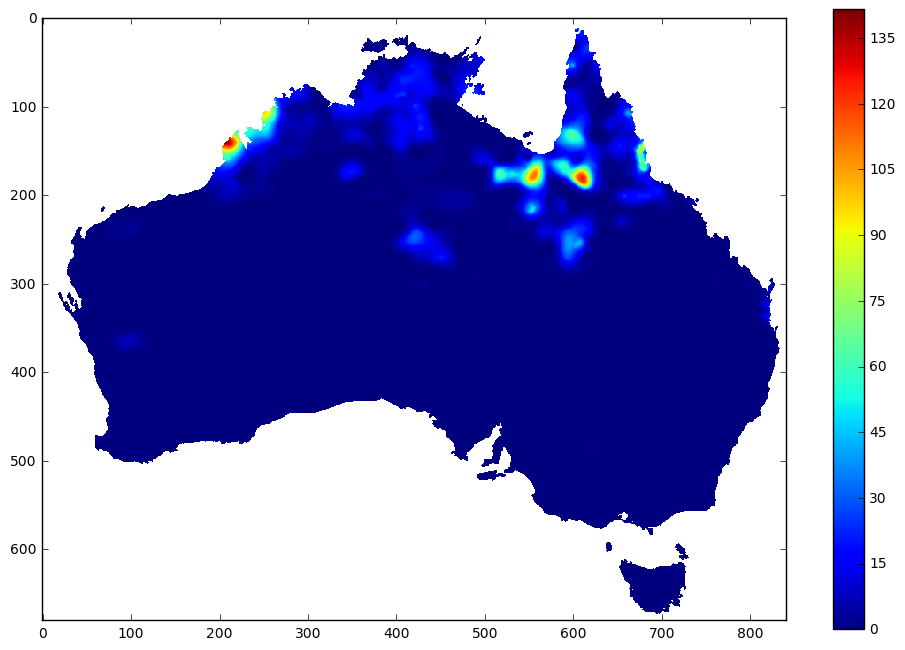

In [69]:
# Rainfall input on the first day of simulation

im = plt.imshow(nodes.get_expanded(ires['pt'][0],edef.mask),interpolation='None')
plt.colorbar(im)

#### 7.2 Run with a uniform rain input across the country

In [70]:
input_map.pt = nodes.const(1000)

In [ ]:
runner = ondemand.OnDemandSimulator(awralmod,input_map)

Rebuilding model
/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/models/awral/core/awral.h
/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/models/awral/core/build_cache/awral_7980dcee8a7d8cdf6ee5e6699a00005a.h


In [ ]:
fixedpt = runner.run(period,edef)

In [ ]:
im = plt.imshow(nodes.get_expanded(fixedpt['qtot'][0],edef.mask),interpolation='None')
plt.colorbar(im)

### 8. Exercise

1. Run the model over the same catchment multiple times, each time with a different parameter value for a parameter of your choice. Then plot the parameter values vs the average flow over the modelled period.